This is a slightly involved classification notebook - using superpixels to generate features. The results look good in that we reduce commission errors. The segmentation might be 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tqdm import tqdm
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from rscube.nd_tools import (get_array_from_features, 
                             get_features_from_array, 
                             get_superpixel_area_as_features, 
                             get_superpixel_means_as_features,
                             get_superpixel_stds_as_features, 
                             scale_img, apply_func_to_superpixels)
from rscube.rio_tools import (get_geopandas_features_from_array, 
                              rasterize_shapes_to_array, 
                              get_indices_from_extent, get_cropped_profile)

from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb, slic
from skimage.color import label2rgb
from pprint import pprint
import geopandas as gpd
from rasterio import plot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import geopandas as gpd
from shapely.geometry import box
from rasterio.windows import Window
from pathlib import Path
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import joblib
from rscube.s1_lulc import get_s1_lulc_data
from rscube.peckel import get_peckel_occ_raster

In [3]:
PLANET_ID = '20211003_161639_91_241d'
TRAINING_TYPE = 'peckel'

In [4]:
assert(TRAINING_TYPE in ['peckel', 's1_lulc'])

In [5]:
planet_image_path = Path(f'local_chips/{PLANET_ID}_3B_AnalyticMS_SR_8b.tif')
planet_image_path.exists()

True

# Path

In [6]:
out_class_dir = Path(f'classification_outputs_{TRAINING_TYPE}/{PLANET_ID}')
out_class_dir.mkdir(exist_ok=True, parents=True)

# Load Chips

Want to crop image based on chip

In [7]:
df = gpd.read_file('s3://opera-calval-database-dswx/site.geojson')
df.dropna(inplace=True)
df.head()

,site_name,water_content,geometry
0,3_42,3.0,"POLYGON ((-122.95236 57.91514, -122.78589 57.9..."
1,4_21,4.0,"POLYGON ((-72.05120 55.21516, -71.89605 55.215..."
2,2_8,2.0,"POLYGON ((-70.87008 -52.06500, -70.72517 -52.0..."
3,4_3,4.0,"POLYGON ((33.56456 -16.33480, 33.56454 -16.245..."
4,4_34,4.0,"POLYGON ((-96.70081 62.77517, -96.57702 62.775..."


In [8]:
df.shape

(130, 3)

In [9]:
with rasterio.open(planet_image_path) as ds:
    image_crs = ds.crs
    image_box = box(*ds.bounds)
    image_bounds = list(ds.bounds)
    image_profile = ds.profile
    image_shape = image_profile['height'], image_profile['width']

image_shape

(10003, 13622)

In [10]:
df_utm = df.to_crs(image_crs)
intersects = df_utm.geometry.intersects(image_box)
df_chip = df_utm[intersects].reset_index(drop=True)
df_chip.head()

,site_name,water_content,geometry
0,3_40,3.0,"POLYGON ((227387.352 3663391.783, 237351.958 3..."


It's a little weird because all Planet Imagery is in UTM and Chips are in Lon/Lat.

In [11]:
(start_y, start_x), (stop_y, stop_x) = get_indices_from_extent(image_profile['transform'],
                                                               list(df_chip.total_bounds),
                                                               shape=image_shape)
window = Window.from_slices((start_y, stop_y), (start_x, stop_x))
sx, sy = np.s_[start_x: stop_x], np.s_[start_y: stop_y]
profile_cropped = get_cropped_profile(image_profile, sx, sy)

We are going to label things based on the chip index.

In [12]:
index = df_chip.site_name[0]
index

'3_40'

In [13]:
with rasterio.open(planet_image_path) as ds:
    image_c = ds.read(window=window)
    image_c = image_c.transpose([1, 2, 0]).astype(np.float32)
image_c.shape

(3415, 3417, 8)

In [14]:
with rasterio.open(planet_image_path) as ds:

    t = ds.tags()
    d = ds.descriptions
    
list(enumerate(d))

[(0, 'coastal_blue'),
 (1, 'blue'),
 (2, 'green_i'),
 (3, 'green'),
 (4, 'yellow'),
 (5, 'red'),
 (6, 'rededge'),
 (7, 'nir')]

In [15]:
mask = (image_c[..., 0] == image_profile['nodata'])
image_c[mask, :] = np.nan

In [16]:
rgb = scale_img(image_c[..., [7, 5, 3]])
# plt.imshow(rgb)

In [17]:
image = image_c[..., [7, 5, 3]]

image_view = image.copy()
for k in tqdm(range(3)):
    m0 = np.nanpercentile(image[~mask, k], 2)
    m1 = np.nanpercentile(image[~mask, k], 98)
    image_view[~mask, k] = np.clip(image[~mask, k], m0, m1)

100%|███████████████████████████████████████| 3/3 [00:02<00:00,  1.46it/s]


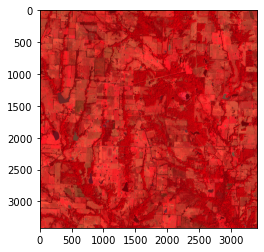

In [18]:
rgb = scale_img(image_view)
plt.imshow(rgb)

In [19]:
p_cropped = profile_cropped.copy()
p_cropped['count'] = 3
p_cropped['dtype'] = 'float32'
p_cropped['nodata'] = np.nan
with rasterio.open(out_class_dir / f'chip_cropped_{PLANET_ID}.tif', 'w', **p_cropped) as ds:
    ds.write(rgb.transpose([2, 0, 1]))

You could use the above to figure out some training data. We label it `training_data_{index}`, according to the chip ID.

# Segmentation

Going to use multiscale superpixels - see [this paper](https://www.mdpi.com/2072-4292/12/12/2048) and the references. I learned about them [here](https://link.springer.com/chapter/10.1007/978-94-017-7239-6_8).

Best discussion of felzenswalb algorithm (and parameters below) is by a another JPL team: https://ieeexplore.ieee.org/document/5593215

In [20]:
def get_segmentation(image, min_size):
    mask_temp = np.isnan(image[...,0])
    image_seg = image.copy()
    # So that np.nans don't give us problems
    image_seg[mask_temp, :] = 0
    segments_fz = slic(image_seg,
                               # may want to play with this
                               compactness=7, 
                               # normally gaussian filter is applied - can experiment
                               sigma=0.0,
                               # minimum size of segments
                               n_segments= int((mask_temp).size / min_size), 
                               start_label=1,
                              )
    segments_fz[np.isnan(image[...,0])] = 0
    return segments_fz

We are going to use the RGB image from above.

In [21]:
get_segmentation_partial = lambda min_size: get_segmentation(rgb, min_size)
segmentations = list(map(get_segmentation_partial, tqdm([15, 30, 60])))

100%|███████████████████████████████████████| 3/3 [00:40<00:00, 13.42s/it]


Below would be used to save the segments to a vector file. It takes some time and the segments can be approximately ~1 GB.

In [22]:
segments_fz = segmentations[0]

In [23]:
%%time

# features = get_geopandas_features_from_array(segments_fz.astype(np.int32), 
#                                              profile['transform'], 
#                                              label_name='label')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


In [24]:
%%time

# df_segments = gpd.GeoDataFrame.from_features(features)
# df_segments.head()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [25]:
%%time

# df_segments.crs = profile['crs']
# df_segments.to_file('segments.geojson', driver='GeoJSON')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


# Generate Features

In [26]:
rgb.shape

(3415, 3417, 3)

In [27]:
# pixel_features = rgb.reshape((-1, rgb.shape[-1]))

In [28]:
multi_superpixel_features_mean = [get_superpixel_means_as_features(seg, rgb) for seg in tqdm(segmentations)]
multi_superpixel_features_mean[0].shape

100%|███████████████████████████████████████| 3/3 [00:05<00:00,  1.69s/it]


(723021, 3)

In [29]:
#multi_superpixel_features_std = [get_superpixel_stds_as_features(seg, rgb) for seg in tqdm(segmentations)]

In [30]:
multi_superpixel_means = [get_array_from_features(seg, feature) 
                          for (seg, feature) in zip(tqdm(segmentations),                                                                                                     multi_superpixel_features_mean)]

100%|███████████████████████████████████████| 3/3 [00:12<00:00,  4.00s/it]


In [31]:
scale_ind = 0
img_super = multi_superpixel_means[scale_ind]
p_superp = p_cropped.copy()
p_superp['count'] = 3

with rasterio.open(out_class_dir / f'superpixel_means_scale-{scale_ind}_{PLANET_ID}.tif', 'w', **p_superp) as ds:
    ds.write(img_super.transpose([2, 0, 1]))

In [32]:
# multi_superpixel_stds = [get_array_from_features(seg, feature) 
#                           for (seg, feature) in zip(tqdm(segmentations),                                                                                                     multi_superpixel_features_std)]

In [33]:
multi_superpixel_features_mean[0].shape

(723021, 3)

In [34]:
multi_means_features = [multi_superpixel_features_mean[0]] + [get_superpixel_means_as_features(segmentations[0], arr[..., k]) for arr in tqdm(multi_superpixel_means[1:]) for  k in range(3)]

100%|███████████████████████████████████████| 2/2 [00:03<00:00,  1.67s/it]


In [35]:
# multi_stds_features = [multi_superpixel_features_std[0]] + [get_superpixel_means_as_features(segmentations[0], arr[..., k]) for arr in tqdm(multi_superpixel_stds[1:]) for  k in range(3)]

In [36]:
all_features = np.hstack((#[]
                          #+ [pixel_features]  
                          multi_means_features
                          #+ multi_stds_features
                          # + superpixel_stds_pixel_f
                         ))
all_features.shape

(723021, 9)

# Generate Training Data

Using Copernicus Sent2 10 meter data

In [37]:
extent = df_chip.to_crs(4326).total_bounds

In [38]:
if TRAINING_TYPE == 's1_lulc':
    X_s1_lulc, p_s1_lulc = get_s1_lulc_data(extent)
    p_training = p_s1_lulc.copy()
    
    with rasterio.open(out_class_dir / f's1_full_landcover_{PLANET_ID}.tif', 'w', **p_s1_lulc) as ds:
        ds.write(X_s1_lulc, 1)
        
    X_training = (X_s1_lulc == 1).astype(np.float32)
    X_training[X_s1_lulc == p_s1_lulc['nodata']] = np.nan
    
    p_training = p_s1_lulc.copy()
    p_training['nodata'] = np.nan
    p_training['dtype'] = 'float32'
    
elif TRAINING_TYPE == 'peckel':
    X_occ, p_occ = get_peckel_occ_raster(extent)
    
    with rasterio.open(out_class_dir / f'occurence_{PLANET_ID}.tif', 'w', **p_occ) as ds:
        ds.write(X_occ, 1)
    
    p_training = p_occ.copy()
    p_training['nodata'] = np.nan
    p_training['dtype'] = 'float32'
    
    X_training = np.full(X_occ.shape, np.nan, dtype=np.float32)
    OCC_MIN = 30
    water_ind = (X_occ >= OCC_MIN)
    land_ind = (X_occ == 0)
    
    X_training[water_ind] = 1
    X_training[land_ind] = 0

In [39]:
with rasterio.open(out_class_dir / f'{TRAINING_TYPE}_training_{PLANET_ID}.tif', 'w', **p_training) as ds:
    ds.write(X_training, 1)

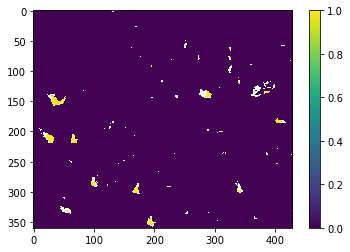

In [40]:
plt.imshow(X_training, interpolation='none')
plt.colorbar()

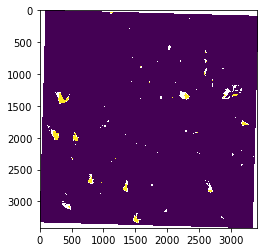

In [41]:
training_data_r, p_r = reproject_arr_to_match_profile(X_training, 
                                                      p_training, 
                                                      p_cropped, 
                                                      resampling='nearest')

training_data_r = training_data_r[0, ...].round()

plt.imshow(training_data_r, interpolation='none')

In [42]:
with rasterio.open(out_class_dir/f'training_data_reprojected_{PLANET_ID}.tif', 'w', **p_r) as ds:
    ds.write(training_data_r, 1)

In [43]:
labels = training_data_r.copy()

In [44]:
%%time

f = lambda x: x.sum() / x.size
percent_class_features = apply_func_to_superpixels(f, segmentations[0], labels)
percent_class_array = get_array_from_features(segmentations[0], percent_class_features)


CPU times: user 8.68 s, sys: 178 ms, total: 8.86 s
Wall time: 8.86 s


In [45]:
with rasterio.open(out_class_dir/f'percent_class_features_{PLANET_ID}.tif', 'w', **p_r) as ds:
    ds.write(percent_class_array, 1)

In [46]:
mask_features = get_features_from_array(segmentations[0], mask.astype(int)).astype(bool)

In [47]:
labels_f = np.full(percent_class_features.shape, np.nan, np.float32)
labels_f[percent_class_features <.05] = 0
labels_f[percent_class_features >.95] = 1

f_mask = mask_features | np.isnan(labels_f)

# Train Model

In [48]:
rf = RandomForestClassifier(n_estimators=500,
                            oob_score=True,
                            random_state=0,
                            n_jobs=5,
                            warm_start=False,
                            class_weight={0: .5, 1: .5})


There must be a better way to do this - this makes sure training data has equal water and land, the later which is much more over-represented. Think something like this will do: https://imbalanced-learn.org/stable/auto_examples/applications/plot_multi_class_under_sampling.html#sphx-glr-auto-examples-applications-plot-multi-class-under-sampling-py/

In [49]:
X_labeled_all = all_features[~f_mask.ravel(), ...]
y_labeled_all = labels_f[~f_mask]

In [50]:
np.unique(y_labeled_all)

array([0., 1.], dtype=float32)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled_all, 
                                                    y_labeled_all, 
                                                    test_size=0.1,
                                                    train_size=0.1,
                                                    random_state=0,
                                                    stratify=y_labeled_all
                                                    )

In [52]:
%%time

print(f'The Peckel data has water: {1 in np.unique(y_labeled_all)}')

rf_path = Path('rf.joblib')


if (1 not in np.unique(y_labeled_all)):
    rf_prev = joblib.load(rf_path)
    rf = rf_prev
else:  
    rf.fit(X_train, 
           y_train)


The Peckel data has water: True
CPU times: user 1min 9s, sys: 773 ms, total: 1min 10s
Wall time: 15.9 s


In [53]:
%%time

y_pred = rf.predict(X_test)

CPU times: user 1.87 s, sys: 77.2 ms, total: 1.95 s
Wall time: 424 ms


In [54]:
class_dict = {0: 'not_water', 
              1: 'water'}

In [55]:
y_pred_str = pd.Series([class_dict[class_id] for class_id in y_pred], name='Predicted')
y_true_str = pd.Series([class_dict[class_id] for class_id in y_test], name='True')

This gives us how well we did on the labeled test data. Random forests will do pretty well on the labeled data since the labeled data is continugous and the superpixels aggregations will likely be shared across pixels.

In [56]:
df_conf = pd.crosstab(y_true_str, y_pred_str)
df_conf

Predicted,not_water,water
True,,
not_water,67612,14
water,41,268


In [57]:
mask_features.shape

(723021, 1)

In [58]:
X_all = all_features[~mask_features.ravel(), 
                     ...]

In [59]:
%%time

y_all_temp = rf.predict(X_all)

CPU times: user 17.1 s, sys: 743 ms, total: 17.9 s
Wall time: 3.68 s


In [60]:
y_all = np.zeros(mask_features.shape)
y_all[~mask_features] = y_all_temp

In [61]:
y_arr = get_array_from_features(segmentations[0], y_all.reshape(-1, 1))

y_arr[mask] = 255

In [62]:
p = profile_cropped.copy()
p['count'] = 1 
p['dtype'] = np.uint8
p['nodata'] = 255
with rasterio.open(out_class_dir / f'classification_{PLANET_ID}.tif', 'w', **p) as ds:
    ds.write(y_arr.astype(np.uint8), 1)

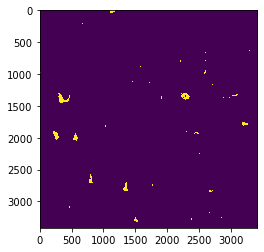

In [63]:
y_arr_plot = y_arr.astype(float)
y_arr_plot[y_arr_plot == 255] = np.nan
plt.imshow(y_arr_plot, interpolation='none', vmax=1)

# Feature Importances

See: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_

In [64]:
rf.feature_importances_

array([0.13664347, 0.02905823, 0.02801639, 0.29196514, 0.03072279,
       0.03066615, 0.368901  , 0.03542821, 0.04859862])

# Save Data

In [65]:
chip_data = df_chip.to_dict('record')[0]
chip_data

/var/folders/s6/fbsc26cd0ddffbp3_knts_9c0wcxj1/T/ipykernel_48861/4294218237.py:1: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  chip_data = df_chip.to_dict('record')[0]


{'site_name': '3_40',
 'water_content': 3.0,
 'geometry': <shapely.geometry.polygon.Polygon at 0x1d1a7cc40>}

In [66]:
df_conf.to_dict()

{'not_water': {'not_water': 67612, 'water': 41},
 'water': {'not_water': 14, 'water': 268}}

In [67]:
fi = list(map(lambda x: f'{x:06f}', rf.feature_importances_))

In [68]:
BUCKET_NAME = 'opera-calval-dswx-jupyter'

In [69]:
chip_data

{'site_name': '3_40',
 'water_content': 3.0,
 'geometry': <shapely.geometry.polygon.Polygon at 0x1d1a7cc40>}

In [70]:
class_data = {'geometry': chip_data['geometry'],
              'feature_list': 'pixels (rgb) ,mean_superpixel (rgb for 3 segs),std_superpixels for rgb image (rgb for 3 segs)',
              'feature_importances': ','.join(fi),
              'accuracy': df_conf.to_dict(),
              's3_bucket': BUCKET_NAME,
              's3_prefix': str(out_class_dir),
              's3_keys': ','.join([x.name for x in sorted(list(out_class_dir.glob('*')))]),
              'chip_id': chip_data['site_name'],
              'strata': chip_data['water_content'],
              'planet_id': PLANET_ID,
              'auxiliary_training': TRAINING_TYPE,
              'class_breakdown': {int(c): y_arr[~mask].size / (~mask.astype(int)).sum() 
                                  for c in np.unique(y_arr) if c != 255},
             }
class_data

{'geometry': <shapely.geometry.polygon.Polygon at 0x1d1a7cc40>,
 'feature_list': 'pixels (rgb) ,mean_superpixel (rgb for 3 segs),std_superpixels for rgb image (rgb for 3 segs)',
 'feature_importances': '0.136643,0.029058,0.028016,0.291965,0.030723,0.030666,0.368901,0.035428,0.048599',
 'accuracy': {'not_water': {'not_water': 67612, 'water': 41},
  'water': {'not_water': 14, 'water': 268}},
 's3_bucket': 'opera-calval-dswx-jupyter',
 's3_prefix': 'classification_outputs_peckel/20211003_161639_91_241d',
 's3_keys': 'chip_cropped_20211003_161639_91_241d.tif,classification_20211003_161639_91_241d.tif,occurence_20211003_161639_91_241d.tif,peckel_training_20211003_161639_91_241d.tif,percent_class_features_20211003_161639_91_241d.tif,superpixel_means_scale-0_20211003_161639_91_241d.tif,training_data_reprojected_20211003_161639_91_241d.tif',
 'chip_id': '3_40',
 'strata': 3.0,
 'planet_id': '20211003_161639_91_241d',
 'auxiliary_training': 'peckel',
 'class_breakdown': {0: -1.0, 1: -1.0}}

In [71]:
df_out = gpd.GeoDataFrame([class_data],
                           crs=df_chip.crs)

In [72]:
df_out.to_file(out_class_dir / f'metadata.geojson', driver='GeoJSON')


# Save Running Model

Save model if does not exist

In [73]:
if not rf_path.exists():
    joblib.dump(rf, f'rf.joblib') 

    rf = None